# Coefficent of Variation Jupyter Notebook

Python code to implement coefficient of variation (CV) for crop/non-crop classification using a Receiver Operating Characteristic (ROC) curve for a time-series of SAR images. The notebook statistically calculates the CV for a stack of time-series imagery. The CV output is then used to generate a ROC curve by using the USDA Cropland Data Layer (CDL) or the Copernicus Global Land Cover layer (GLC) as ground truth. Pixels classified by the reference as "Water" are masked and not used in classification because, water has a high variation measurement not comparable to the CV values of other non-cropland land covers and is often missclassified because of this. The statistic Youden's Index is calculated to detemine the ideal threshold on the curve to use for best classification results. The accuracy of the classification compared to the reference as ground truth are calculated for the CV crop/non-crop classification. The classified image is exported as a Geotiff. A CSV file is exported containing accuracy statistics for the classification.

Coefficient of Variation is calculated by: Standard Deviation/Mean

Created by: Shannon Rose, Microwave Remote Sensing Labratory (MIRSL) Unuversity of Massachusetts- Amherst

Modified by: Kaylee Sharp (kaylee.g.sharp@nasa.gov / kaylee.sharp@uah.edu), University of Alabama in Huntsville (November 2022)

Datasets needed:

    Timeseries of SAR imagery
    
    CDL available at https://nassgeodata.gmu.edu/CropScape/

# Data Flow Model for Notebook

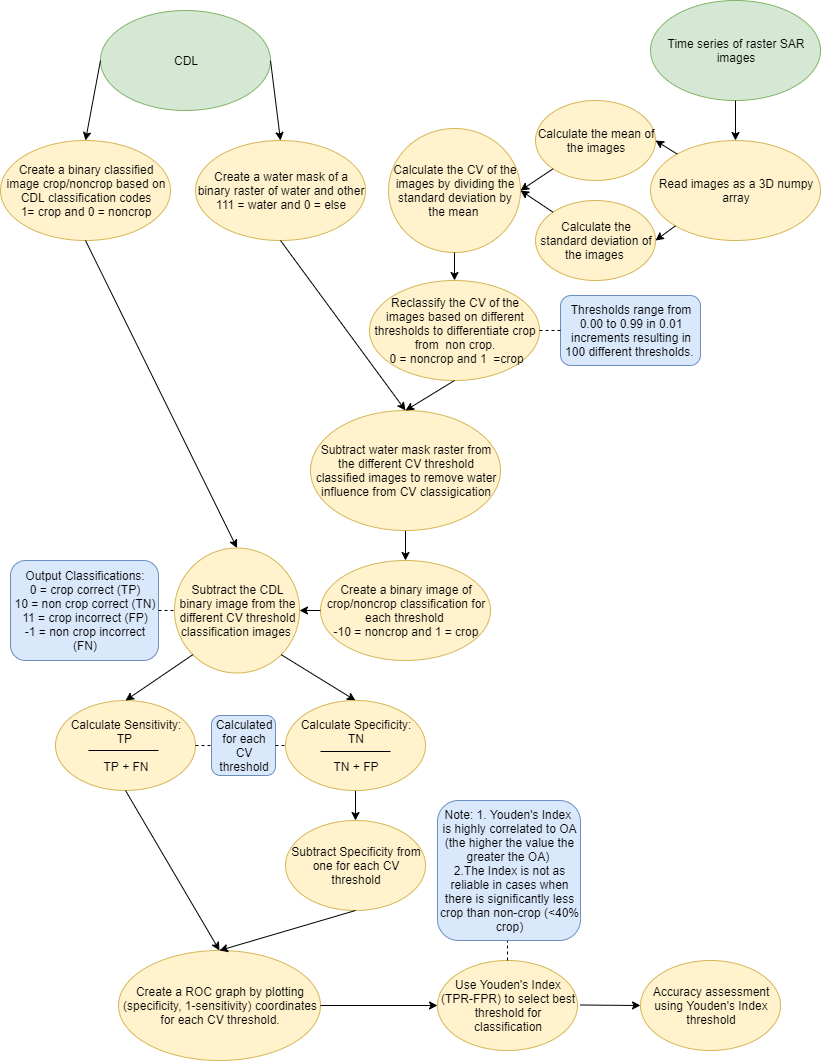

# Needed libraries

This code runs using Python 3.7 and has the following libraries installed

1. numpy
2. matplotlib
3. gdal
4. scipy
5. pandas
6. scikit-learn
7. ipywidgets
8. rasterio

<code> conda install numpy matplotlib gdal scipy pandas scikit-learn ipywidgets rasterio </code>

# Import Python Modules

In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from osgeo import gdal, osr, ogr
gdal.UseExceptions()
import subprocess
import os
import time
import scipy
import pandas as pd
from pathlib import Path
import sys
from pandas import DataFrame
from IPython.display import Image
import sklearn  # imported from scikit-learn
from sklearn import metrics
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
%matplotlib inline
from ipywidgets import interactive
from rasterio.plot import show_hist
plt.rcParams.update({'font.size': 14})

In [ ]:
print(sys.version)
print('the above number should be 3.7.something')
print(sys.path)

In [ ]:
# Added by Jordan Bell on 11/9/2021
# from https://github.com/jgomezdans/eoldas_ng_observations/blob/reference/eoldas_ng_observations/eoldas_observation_helpers.py#L29
def reproject_image_to_reference(reference, input_file, output_file, res=None): 
    """This function reprojects an image (``input_file``) to
    match the extent, resolution and projection of another
    (``reference``) using GDAL. The newly reprojected image
    is a GDAL VRT file for efficiency. A different spatial
    resolution can be chosen by specifyign the optional
    ``res`` parameter. The function returns the new file's
    name.
    Parameters
    -------------
    reference: str 
        A filename (with full path if required) with the 
        reference image (that that will be taken as a reference)
    input_file: str 
        A filename (with path if needed) with the image
        that will be reprojected
    res: float, optional
        The desired output spatial resolution, if different 
        to the one in ``reference``.
    Returns
    ----------
    The reprojected filename
    TODO Have a way of controlling output filename
    """
    input_file_ds = gdal.Open( input_file )
    if input_file_ds is None:
        print("GDAL could not open input_file file %s " % input_file)
    input_file_proj = input_file_ds.GetProjection()
    input_file_geotrans = input_file_ds.GetGeoTransform()
    data_type = input_file_ds.GetRasterBand(1).DataType
    n_bands = input_file_ds.RasterCount

    reference_ds = gdal.Open( reference )
    if reference_ds is None:
        print("GDAL could not open reference file %s " % reference)
    reference_proj = reference_ds.GetProjection()
    reference_geotrans = reference_ds.GetGeoTransform()
    w = reference_ds.RasterXSize
    h = reference_ds.RasterYSize
    if res is not None:
        reference_geotrans[1] = float( res )
        reference_geotrans[-1] = - float ( res )

    dst_filename = output_file #input_file.replace( ".tif", "_crop.vrt" )
    #dst_ds = gdal.GetDriverByName('VRT').Create(dst_filename,
    #                                           w, h, n_bands, data_type)
    dst_ds = gdal.GetDriverByName('GTiff').Create(dst_filename,
                                                w, h, n_bands, data_type)
    dst_ds.SetGeoTransform( reference_geotrans )
    dst_ds.SetProjection( reference_proj)

    gdal.ReprojectImage( input_file_ds, dst_ds, input_file_proj,
                         reference_proj, gdal.GRA_NearestNeighbour)
    dst_ds = None  # Flush to disk
    return dst_filename

In [ ]:
# Define write_geotiff function - writes an array to a geotiff
def write_geotiff_export(image, geotrans, cols, rows, spatial_ref, nodata, outfilename):    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(outfilename, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform(geotrans)
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(image)
    outRasterSRS = osr.SpatialReference()
    outband.SetNoDataValue(np.nan)
    outRasterSRS.ImportFromWkt(spatial_ref)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

# Set the Input/Output Parameters

Note: 
    1. For use in this notebook all raster datasets must be set to the same grid with pixels aligned
    2. The only data that can be in the set "SAR_image_folder" is the timeseries SAR imagery

In [ ]:
name = "Iowa_tile_SAR_stack"

time_series_path = f"s3://asf-jupyter-data-west/{name}.zip"
time_series = Path(time_series_path).name
!aws --region=us-west-2 --no-sign-request s3 cp $time_series_path $time_series

!unzip {name}.zip
!rm *.zip

In [ ]:
main_dir = os.getcwd()

#input parameters

SAR_image_folder = r'/home/jovyan/notebooks/SAR_Training/English/HydroSAR/15TWF'
ref_image_folder = r'/home/jovyan/notebooks/SAR_Training/English/HydroSAR/15TWF/cdl_tile'

reference = os.path.join(ref_image_folder, 'CDL_2018_clip_20220912120614_483234605.tif')

# output parameters
Output_folder = r'/home/jovyan/notebooks/SAR_Training/English/HydroSAR/AGmapping_output'
OF = Path(f"/home/jovyan/notebooks/SAR_Training/English/HydroSAR/AGmapping_output")
if not OF.exists():
    OF.mkdir()
J_CV_classification_binary = "J_CV_classification_final"

# CDL Preparation

All crops are set to 1. Everything else is set to 0.

Uncomment cdl_reclass if you are using the USDA Cropland Data Layer as your reference.

Uncomment glc_reclass if you are using the Copernicus Global Land Cover layer as your reference.

In [ ]:
def cdl_reclass(reference_in, wmoutput = False, output = False):
    
    # Get dimensions of CDL
    ds = gdal.Open(reference_in)
    rows1 = ds.RasterYSize
    cols1 = ds.RasterXSize
    cdl_in = ds.ReadAsArray(0, 0, cols1, rows1)

    CDL_geotransform = ds.GetGeoTransform()
    CDL_xres = CDL_geotransform[1]
    CDL_yres = -CDL_geotransform[5]
    CDL_xmin = CDL_geotransform[0]
    CDL_ymax = CDL_geotransform[3]
    CDL_spatialref = ds.GetProjectionRef()

    #Water Mask
    water_mask = np.zeros(np.shape(cdl_in), dtype = 'byte')
    #print(np.shape(water_mask))
    cdl111 = len(water_mask[np.where(cdl_in == 111)])
    print("Number of Pixels Masked for Water:", cdl111)
    cdl0 = len(water_mask[np.where(cdl_in != 111)])
    print("Number of Pixels for Classification",cdl0)
    water_mask = cdl_in == 111

    filenamesplit = os.path.basename(reference_in)
    split = filenamesplit.split('.')

    filen = split[0]+ '_waterMask.tif' 
    filename = os.path.join(ref_image_folder,filen)
    if output == True:
          format = 'GTiff'
          rows, cols = np.shape(cdl_in)
          driver = gdal.GetDriverByName(format)
          out_ds = driver.Create(filename, cols, rows, 1, gdal.GDT_Byte)
          out_cs = osr.SpatialReference()
          out_cs.ImportFromWkt(CDL_spatialref)
          out_ds.SetProjection(out_cs.ExportToWkt())
          out_ds.SetGeoTransform(CDL_geotransform)
          out_ds.GetRasterBand(1).WriteArray(water_mask)
          out_ds = None

    CDL_crop = np.copy(cdl_in)
    unique = np.unique(cdl_in)
    uniquecount = len(unique)

    # Setting all crop classification values equal to 1 
    CDL_crop[np.where(cdl_in == 1)]= 1    #Corn
    CDL_crop[np.where(cdl_in == 2)]= 1    #Cotton
    CDL_crop[np.where(cdl_in == 3)]= 1    #Rice
    CDL_crop[np.where(cdl_in == 4)]= 1    #Sorghum
    CDL_crop[np.where(cdl_in == 5)]= 1    #Soybeans
    CDL_crop[np.where(cdl_in == 6)]= 1    #Sunflower
    CDL_crop[np.where(cdl_in == 10)]= 1    #Peanuts
    CDL_crop[np.where(cdl_in == 11)]= 1    #Tobacco
    CDL_crop[np.where(cdl_in == 12)]= 1    #Sweet Corn
    CDL_crop[np.where(cdl_in == 13)]= 1    #Pop or Orn Corn
    CDL_crop[np.where(cdl_in == 14)]= 1    #Mint
    CDL_crop[np.where(cdl_in == 21)]= 1    #Barley
    CDL_crop[np.where(cdl_in == 22)]= 1    #Durum Wheat
    CDL_crop[np.where(cdl_in == 23)]= 1    #Spring Wheat
    CDL_crop[np.where(cdl_in == 24)]= 1    #Winter Wheat
    CDL_crop[np.where(cdl_in == 25)]= 1    #Other small grains
    CDL_crop[np.where(cdl_in == 26)]= 1    #Dbl crop WinWht/Soybeans
    CDL_crop[np.where(cdl_in == 27)]= 1    #Rye
    CDL_crop[np.where(cdl_in == 28)]= 1    #Oats
    CDL_crop[np.where(cdl_in == 29)]= 1    #Millet
    CDL_crop[np.where(cdl_in == 30)]= 1    #Speltz
    CDL_crop[np.where(cdl_in == 31)]= 1    #Canola
    CDL_crop[np.where(cdl_in == 32)]= 1    #Flaxseed
    CDL_crop[np.where(cdl_in == 33)]= 1    #Safflower
    CDL_crop[np.where(cdl_in == 34)]= 1    #Rape Seed
    CDL_crop[np.where(cdl_in == 35)]= 1    #Mustard
    CDL_crop[np.where(cdl_in == 36)]= 1    #Alfalfa
    #CDL_crop[np.where(cdl_in == 37)]= 1    #Other Hay/Non Alfalfa---- could be omitted
    CDL_crop[np.where(cdl_in == 38)]= 1    #Camelina
    CDL_crop[np.where(cdl_in == 39)]= 1    #Buckwheat
    CDL_crop[np.where(cdl_in == 41)]= 1    #Sugarbeets
    CDL_crop[np.where(cdl_in == 42)]= 1    #Dry Beans
    CDL_crop[np.where(cdl_in == 43)]= 1    #Potatoes
    CDL_crop[np.where(cdl_in == 44)]= 1    #Other Crops
    CDL_crop[np.where(cdl_in == 45)]= 1    #Sugarcane
    CDL_crop[np.where(cdl_in == 46)]= 1    #Sweet Potatoes
    CDL_crop[np.where(cdl_in == 47)]= 1    #Misc Vegs & Fruits
    CDL_crop[np.where(cdl_in == 48)]= 1    #Watermelons
    CDL_crop[np.where(cdl_in == 49)]= 1    #Onions
    CDL_crop[np.where(cdl_in == 50)]= 1    #Cucumbers
    CDL_crop[np.where(cdl_in == 51)]= 1    #Chick Peas
    CDL_crop[np.where(cdl_in == 52)]= 1    #Lentils
    CDL_crop[np.where(cdl_in == 53)]= 1    #Peas
    CDL_crop[np.where(cdl_in == 54)]= 1    #Tomatoes
    CDL_crop[np.where(cdl_in == 55)]= 1    #Cranberries
    CDL_crop[np.where(cdl_in == 56)]= 1    #Hops
    CDL_crop[np.where(cdl_in == 57)]= 1    #Herbs
    CDL_crop[np.where(cdl_in == 58)]= 1    #Clover/Wildflowers
    #CDL_crop[np.where(cdl_in == 59)]= 1    #Sod/Grass Seed---- could be omitted
    #CDL_crop[np.where(cdl_in == 60)]= 1    #Switchgrass---- could be omitted
    CDL_crop[np.where(cdl_in == 61)]= 1    #Fallow/Idle Cropland
    CDL_crop[np.where(cdl_in == 66)]= 1    #Cherries
    CDL_crop[np.where(cdl_in == 67)]= 1    #Peaches
    CDL_crop[np.where(cdl_in == 68)]= 1    #Apples
    CDL_crop[np.where(cdl_in == 69)]= 1    #Grapes
    CDL_crop[np.where(cdl_in == 70)]= 1    #Christmas Trees
    CDL_crop[np.where(cdl_in == 71)]= 1    #Other Tree Crops    
    CDL_crop[np.where(cdl_in == 72)]= 1    #Citrus
    CDL_crop[np.where(cdl_in == 74)]= 1    #Pecans
    CDL_crop[np.where(cdl_in == 75)]= 1    #Almonds
    CDL_crop[np.where(cdl_in == 76)]= 1    #Walnuts
    CDL_crop[np.where(cdl_in == 77)]= 1    #Pears
    #CDL_crop[np.where(cdl_in == 121)]= 1   #Developed/Open Space
    #CDL_crop[np.where(cdl_in == 176)]= 1   #Grassland/Pasture
    CDL_crop[np.where(cdl_in == 204)]= 1    #Pistachios
    CDL_crop[np.where(cdl_in == 205)]= 1    #Triticale
    CDL_crop[np.where(cdl_in == 206)]= 1    #Carrots
    CDL_crop[np.where(cdl_in == 207)]= 1    #Asparagus
    CDL_crop[np.where(cdl_in == 208)]= 1    #Garlic
    CDL_crop[np.where(cdl_in == 209)]= 1    #Cantaloupes
    CDL_crop[np.where(cdl_in == 210)]= 1    #Prunes
    CDL_crop[np.where(cdl_in == 211)]= 1    #Olives
    CDL_crop[np.where(cdl_in == 212)]= 1    #Oranges
    CDL_crop[np.where(cdl_in == 213)]= 1    #Honeydew Melons
    CDL_crop[np.where(cdl_in == 214)]= 1    #Broccoli
    CDL_crop[np.where(cdl_in == 216)]= 1    #Peppers
    CDL_crop[np.where(cdl_in == 217)]= 1    #Pomegranates
    CDL_crop[np.where(cdl_in == 218)]= 1    #Nectarines
    CDL_crop[np.where(cdl_in == 219)]= 1    #Greens
    CDL_crop[np.where(cdl_in == 220)]= 1    #Plums
    CDL_crop[np.where(cdl_in == 221)]= 1    #Strawberries
    CDL_crop[np.where(cdl_in == 222)]= 1    #Squash
    CDL_crop[np.where(cdl_in == 223)]= 1    #Apricots
    CDL_crop[np.where(cdl_in == 224)]= 1    #Vetch
    CDL_crop[np.where(cdl_in == 225)]= 1    #Dbl Crop WinWht/Corn
    CDL_crop[np.where(cdl_in == 226)]= 1    #Dbl Crop Oats/Corn
    CDL_crop[np.where(cdl_in == 227)]= 1    #Lettuce
    CDL_crop[np.where(cdl_in == 229)]= 1    #Pumpkins
    CDL_crop[np.where(cdl_in == 230)]= 1    #Dbl Crop Lettuce/Drum Wht
    CDL_crop[np.where(cdl_in == 231)]= 1    #Dbl Crop Lettuce/Cantaloupe
    CDL_crop[np.where(cdl_in == 232)]= 1    #Dbl Crop Lettuce/Cotton
    CDL_crop[np.where(cdl_in == 233)]= 1    #Dbl Crop Lettuce/Barley
    CDL_crop[np.where(cdl_in == 234)]= 1    #Dbl Crop Durum Wht/Sorghum
    CDL_crop[np.where(cdl_in == 235)]= 1    #Dbl Crop Barley/Sorghum
    CDL_crop[np.where(cdl_in == 236)]= 1    #Dbl Crop WinWht/Sorghum
    CDL_crop[np.where(cdl_in == 237)]= 1    #Dbl Crop Barley/Corn
    CDL_crop[np.where(cdl_in == 238)]= 1    #Dbl Crop WinWht/Cotton
    CDL_crop[np.where(cdl_in == 239)]= 1    #Dbl Crop Soybeans/Cotton
    CDL_crop[np.where(cdl_in == 240)]= 1    #Dbl Crop Soybeans/Oats
    CDL_crop[np.where(cdl_in == 241)]= 1    #Dbl Crop Corn/Soybeans
    CDL_crop[np.where(cdl_in == 242)]= 1    #Blueberries
    CDL_crop[np.where(cdl_in == 243)]= 1    #Cabbage
    CDL_crop[np.where(cdl_in == 244)]= 1    #Cauliflower
    CDL_crop[np.where(cdl_in == 245)]= 1    #Celery
    CDL_crop[np.where(cdl_in == 246)]= 1    #Radishes
    CDL_crop[np.where(cdl_in == 247)]= 1    #Turnips
    CDL_crop[np.where(cdl_in == 248)]= 1    #Eggplants
    CDL_crop[np.where(cdl_in == 249)]= 1    #Gourds
    CDL_crop[np.where(cdl_in == 250)]= 1    #Cranberries
    CDL_crop[np.where(cdl_in == 254)]= 1    #Dbl Crop Barley/Soybeans

    # Setting all non-crop values to 0 based on assumming that everything not previously classified as crop is non-crop
    CDL_binary = np.copy(CDL_crop)
    CDL_binary[np.where(CDL_crop!= 1)]= 0
    
    plt.set_cmap('viridis')
    plt.imshow(CDL_binary)

    # Getting the number of pixels classified as crop and non-crop including the removal of masked pixels
    #cropcount = np.count_nonzero(CDL_binary == 1)
    cropcount = len(CDL_binary[np.where(CDL_binary == 1)])
    print("Number of crop pixels:", cropcount)

    #noncount = np.count_nonzero(CDL_binary == 0)- cdl111
    noncount = len(CDL_binary[np.where(CDL_binary == 0)])-cdl111
    print("Number of non-crop pixels:",noncount)

    # Finding the percent of pixels classified as crop and non-crop including the removal of masked pixels
    percent_crop_nonmasked_calc = round((cropcount / cdl0)*100, 2)
    print ("% Crop: ", percent_crop_nonmasked_calc)

    percent_noncrop_nonmasked_calc = round((noncount / cdl0)*100, 2)
    print ("% Non-crop: ", percent_noncrop_nonmasked_calc)

    filen = split[0]+'_Reclass.tif' 
    filename = os.path.join(ref_image_folder,filen)
    if output == True:
          format = 'GTiff'
          rows, cols = np.shape(cdl_in)
          driver = gdal.GetDriverByName(format)
          out_ds = driver.Create(filename, cols, rows, 1, gdal.GDT_Byte)
          out_cs = osr.SpatialReference()
          out_cs.ImportFromWkt(CDL_spatialref)
          out_ds.SetProjection(out_cs.ExportToWkt())
          out_ds.SetGeoTransform(CDL_geotransform)
          out_ds.GetRasterBand(1).WriteArray(CDL_binary)
          out_ds = None


In [ ]:
def glc_reclass(reference_in, wmoutput = False, output = False):
    glc_file_in = glob.glob(os.path.join(reference_in, '*.tif*'))
       
    # Get dimensions of CDL
    ds = gdal.Open(reference_in)
    rows1 = ds.RasterYSize
    cols1 = ds.RasterXSize
    glc_in = ds.ReadAsArray(0, 0, cols1, rows1)

    GLC_geotransform = ds.GetGeoTransform()
    GLC_xres = GLC_geotransform[1]
    GLC_yres = -GLC_geotransform[5]
    GLC_xmin = GLC_geotransform[0]
    GLC_ymax = GLC_geotransform[3]
    GLC_spatialref = ds.GetProjectionRef()
    
    #Water Mask
    # Reference: https://zenodo.org/record/4723921#.YTpJP_lKhPY
    water_mask = np.zeros(np.shape(glc_in), dtype = 'byte')
    glcWater = len(water_mask[np.where((glc_in == 80)|(glc_in == 200))])
    print("Number of Pixels Masked for Water:", glcWater)
    glcLand = len(water_mask[np.where((glc_in != 80)|(glc_in != 200))])
    print("Number of Land Pixels:", glcLand)
    water_mask = (glc_in == 80) | (glc_in == 200)

    #plt.imshow(water_mask)

    filenamesplit = os.path.basename(reference_in)
    split = filenamesplit.split('.')

    filen = split[0]+ '_waterMask.tif' 
    filename = os.path.join(ref_image_folder, filen)
    if output == True:
          format = 'GTiff'
          rows, cols = np.shape(glc_in)
          driver = gdal.GetDriverByName(format)
          out_ds = driver.Create(filename, cols, rows, 1, gdal.GDT_Byte)
          out_cs = osr.SpatialReference()
          out_cs.ImportFromWkt(GLC_spatialref)
          out_ds.SetProjection(out_cs.ExportToWkt())
          out_ds.SetGeoTransform(GLC_geotransform)
          out_ds.GetRasterBand(1).WriteArray(water_mask)
          out_ds = None

    GLC_crop = np.copy(glc_in)
    unique = np.unique(glc_in)
    uniquecount = len(unique)

    # Setting all crop classification values equal to 1 
    GLC_crop[np.where(glc_in == 40)] = 1    # All Crops

    # Setting all non-crop values to 0 based on assumming that everything not previously classified as crop is non-crop
    GLC_binary = np.copy(GLC_crop)
    GLC_binary[np.where(GLC_crop != 1)]= 0

    plt.imshow(GLC_binary)

    # Getting the number of pixels classified as crop and non-crop including the removal of masked pixels
    #cropcount = np.count_nonzero(CDL_binary == 1)
    cropcount = len(GLC_binary[np.where(GLC_binary == 1)])
    print("Number of crop pixels:", cropcount)

    #noncount = np.count_nonzero(CDL_binary == 0)- cdl111
    noncount = len(GLC_binary[np.where(GLC_binary == 0)])-glcWater
    print("Number of non-crop pixels:",noncount)

    # Finding the percent of pixels classified as crop and non-crop including the removal of masked pixels
    percent_crop_nonmasked_calc = round((cropcount / glcLand)*100, 2)
    print ("% Crop: ", percent_crop_nonmasked_calc)

    percent_noncrop_nonmasked_calc = round((noncount / glcLand)*100, 2)
    print ("% Non-crop: ", percent_noncrop_nonmasked_calc)

    filen = split[0]+ '_Reclass.tif' 
    filename = os.path.join(ref_image_folder,  filen)
    if output == True:
          format = 'GTiff'
          rows, cols = np.shape(glc_in)
          driver = gdal.GetDriverByName(format)
          out_ds = driver.Create(filename, cols, rows, 1, gdal.GDT_Byte)
          out_cs = osr.SpatialReference()
          out_cs.ImportFromWkt(GLC_spatialref)
          out_ds.SetProjection(out_cs.ExportToWkt())
          out_ds.SetGeoTransform(GLC_geotransform)
          out_ds.GetRasterBand(1).WriteArray(GLC_binary)
          out_ds = None
    return

In [ ]:
cdl_reclass(reference, wmoutput = True, output = True)

#glc_reclass(reference, wmoutput = True, output = True)

# Clipping of Reference Data

In [ ]:
###### Clipping Reference and Watermask ######
ref_old = glob.glob(os.path.join(ref_image_folder, '*Reclass.tif'))[0]
h2o_old = glob.glob(os.path.join(ref_image_folder, '*waterMask.tif'))[0]
match_to = glob.glob(os.path.join(SAR_image_folder, '*.tif*'))

ref_new = ref_old.split('.')[0] + '_clip.tif'
h2o_new = h2o_old.split('.')[0] + '_clip.tif'

reproject_image_to_reference(match_to[0], ref_old, ref_new)
reproject_image_to_reference(match_to[0], h2o_old, h2o_new)

# Creating a Water Mask

Creating a mask to not include pixels in the reference data classified as "Water".
Water has a high variation measurement not comparable to the CV values of other non-cropland land covers and is often missclassified because of this.

The mask sets water (111 values) to 111 and everything else to 0.

In [ ]:
h2o_raster = gdal.Open(h2o_new).ReadAsArray()

watermask = h2o_raster.copy()
watermask[watermask == 1] = 111

#getting the number of pixels masked and not masked 
ref111 = np.count_nonzero(watermask == 111)
print("Number of masked Pixels:", ref111)
ref0 = np.count_nonzero(watermask == 0)
print("Number of pixels for classification:", ref0)
plt.rcParams['figure.figsize'] = (6,5)
cmap = ListedColormap(["g", "b"])
plt.imshow(watermask,interpolation='nearest', cmap=cmap)
print('water pixels are marked as blue')

# Finding the breakdown of crop/non-crop pixels

In [ ]:
#getting the number of pixels classified as crop and non-crop including the removal of masked pixels
ref_binary = gdal.Open(ref_new).ReadAsArray()

cropcount = np.count_nonzero(ref_binary == 1)
print("Number of crop pixels:", cropcount)

noncount = np.count_nonzero(ref_binary == 0)- ref111
print("Number of non-crop pixels:",noncount)

#finding the percent of pixels classified as crop and non-crop including the removal of masked pixels
percent_crop_nonmasked_calc = round((cropcount / ref0)*100, 2)
print ("% Crop: ", percent_crop_nonmasked_calc)

percent_noncrop_nonmasked_calc = round((noncount / ref0)*100, 2)
print ("% Non-crop: ", percent_noncrop_nonmasked_calc)

Plotting crop/non-crop reference map.

In [ ]:
first_raster_ref_new = gdal.Open(ref_new)
ref_new_geotransform = first_raster_ref_new.GetGeoTransform()
rows2 = first_raster_ref_new.RasterYSize
cols2 = first_raster_ref_new.RasterXSize
ref_new_spatialref = first_raster_ref_new.GetProjectionRef()

cmap = ListedColormap(["m", "y"])
plt.imshow(ref_binary,interpolation='nearest', cmap=cmap)
plt.title(f'Crop/Ag Land: Reference ({percent_crop_nonmasked_calc}% crop)')
os.chdir(Output_folder)
write_geotiff_export(ref_binary, ref_new_geotransform, cols2, rows2, ref_new_spatialref, np.nan, 'ReferenceBinary.tif')
os.chdir(main_dir)
print('Crop pixels marked in yellow')
figname = f"{Output_folder}/cropPix.png" 
plt.savefig(figname, dpi=300, bbox_inches = 'tight', transparent='true')

# Bringing in SAR Images

Create a timeseries stack of the SAR imagery

In [ ]:
# Setting the working directory 
os.chdir(SAR_image_folder)

# Selecting the images for the time series-- all "".tif" images in set working directory
SAR_images = glob.glob("*.tif*")

# Read raster files and make them into a 3D numpy array
arrs = []
for image in SAR_images:
    print(image)
    arrs.append(gdal.Open(image).ReadAsArray())
a = np.array(arrs, dtype=float)

# Creating a variable for the number of images (one for each date)
num_dates = len(arrs)
print ("Number of dates:", num_dates)
print(a.shape)

# Get dimensions of the first SAR image--- should be the same for every image in the stack
first_raster = gdal.Open(SAR_images[1])
rows = first_raster.RasterYSize
cols = first_raster.RasterXSize
geotransform = first_raster.GetGeoTransform()
xres = geotransform[1]
yres = -geotransform[5]
xmin = geotransform[0]
ymax = geotransform[3]
spatialref = first_raster.GetProjectionRef()

# Change the directory back to the main directory
os.chdir(main_dir)

Plotting four example SAR images for inspection.

In [ ]:
plt.set_cmap('viridis')
plt.rcParams['figure.figsize'] = (25,12)
plt.subplot(2,2,1)
plt.imshow(10*np.log10(a[0,:,:]),vmin=-22,vmax=-5,interpolation='nearest')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(10*np.log10(a[1,:,:]),vmin=-22,vmax=-5,interpolation='nearest')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(10*np.log10(a[2,:,:]),vmin=-22,vmax=-5,interpolation='nearest')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(10*np.log10(a[3,:,:]),vmin=-22,vmax=-5,interpolation='nearest')
plt.colorbar();


# Calculating the CV on the Timeseries Stack

CV = Standard Deviation / Mean

The coefficient of variation can exceed a value of 1. However, for the purposes of illustration, coefficient of variation values that exceed 1 are given a value of 1.

In [ ]:
# Calculate the mean for the time stack of images
mean = np.mean(a, axis = 0)

# Calculate the standard deviation for the time stack of images
std = np.std(a, axis = 0)

# Calculate the coefficient of variation for the time stack of images 
CV = std/mean
os.chdir(Output_folder)
write_geotiff_export(CV, geotransform, cols, rows, spatialref, np.nan, 'CoVarMap.tif')
os.chdir(main_dir)
plt.set_cmap('viridis')
plt.rcParams['figure.figsize'] = (6,5)
plt.imshow((CV),vmin=0,vmax=1)
plt.title('CoV')
plt.colorbar(fraction=0.046*mean.shape[0]/mean.shape[1],pad=0.04);
figname = f"{Output_folder}/CoVar.png" 
plt.savefig(figname, dpi=300, bbox_inches = 'tight', transparent='true')

## Plotting a histogram of the Coefficient of Variation values.

As above, all coefficient of variation values that exceed 1 are given a value of 1 for this histogram. Therefore, you may notice that a CoV value of 1 has a higher frequency than nearby values in the 0.8-.99 range. 

In [ ]:
fig = plt.figure(figsize=(12, 12)) # Initialize figure with a size
ax1 = fig.add_subplot(111)  # 221 determines: 2 rows, 2 plots, first plot
show_hist(np.clip(CV,0,1.0),bins=50, label='CoVar', ax=ax1)  # this is the only routine that uses rasterio

figname = f"{Output_folder}/CoVar_Histogram.png" 
plt.savefig(figname, dpi=300, bbox_inches = 'tight', transparent='true')

## Plotting the Standard Deviation of the Radar Cross Section.

For comparison, we are also plotting the temporal standard deviation of the radar brightness. While this plot looks similar to the coefficient of variation map, there are some areas where larger differences can be seen (see bottom left corner).

In [ ]:
plt.imshow(std,vmin=0,vmax=0.02,interpolation='nearest');
plt.colorbar(fraction=0.046*std.shape[0]/std.shape[1],pad=0.04);
plt.title('Standard deviation of Radar Cross Section (magnitude)');

# Picking a Threshold Based on Youden's Index (J statistic)

We can determine the optimal threshold to divide our image into crop and non crop by finding the threshold where Youden's Index (J statistic) is highest. 

The highest Youden's Index is the point on the Receiver Operating Characteristic (ROC) curve where sensitivity and specificity are maximized, a maximum difference between the True Positive Rate (sensitivity) and False Positive Rate (1 - specificity). A plot is generated to show the point on the curve where the Youden's Index point is on curve.

To find the optimal thresholds, we will test 100 thresholds (0.00, 0.01, 0.02, ... 1.00). Coefficient of variation may exceed 1. Therefore, all pixels with a CoV greater than 1 will be classified as crop at all thresholds.

For each of our 100 test thresholds:

1. Reclassify our Coefficient of Variation image based on the threshold (reclass_image() function below)
    
    CoV >= threshold --> 1 = crop
    
    CoV < threshold  --> 0 = non crop
    
    Next, Subtract our watermask from our new binary crop / non crop layer
        
        In the watermask raster:
            
            111 = water
            0 = no water
            
        In our crop / non crop classification:
            
            1 = crop
            0 = non crop
        
        After subtracting the watermask from our crop / non crop classification:
            
            crop - water        = 1 - 111 = -110
            crop - no water     = 1 - 0   = 1
            non crop - water    = 0 - 111 = -111
            non crop - no water = 0 - 0   = 0
        
     Reclass our image again so that all pixels containing water map to 0:
     
          -110 --> 0
          -111 --> 0
             
2. Determine how our crop / non crop classificiation compares to the reference raster (diff_ref_CV_reclass() function below)

    Reclass our crop / non crop raster to make subtracting by the reference easier:
        
        classified crop     = 1
        classified non crop = -10
        
    Subtract our crop / non crop classification from the reference raster:
    
        reference crop     = 1
        reference non crop = 0
        
       (reference crop) - (classified crop)         = 1 - 1     = 0  --> true positive (TP)
       (reference non crop) - (classified crop)     = 0 - 1     = -1 --> false positive (FP)
       (reference non crop) - (classified non crop) = 0 - (-10) = 10 --> true negative (TN)
       (reference crop) - (classified non crop)     = 1 - (-10) = 11 --> false negative (FN)
       
       
       
3. Calculate sensitivity, specificity, and precision for each threshold. We also calculate (1 - specificity) for plotting the ROC curve.
    
    Sensitivity (Recall, True Positive Rate) = TP / (TP + FN)
    
    Specificity (True Negative Rate)         = TN / (TN + FP)
    
    Precision                                = TP / (TP + FP)
    
4. Calculate the J statistic for each threshold.

    J = sensitivity + specificity - 1
    

5. Sort the J statistics to determine which threshold results in the highest J statistic. This is our optimal thresholds. 
    

In [ ]:
# function to reclass the the Coefficient of Variation image into a binary crop / non crop image
# crop maps to 1 and non crop maps to 0
# returns reclassed iamge

def reclass_image(threshold):
    CV_reclass_ideal = np.copy(CV)
    CV_reclass_ideal[np.where(CV_reclass_ideal>= threshold)] = 1
    CV_reclass_ideal[np.where(CV_reclass_ideal< threshold)] = 0
    CVideal_water = np.subtract(CV_reclass_ideal, watermask)
    CVideal_water[np.where(CVideal_water <=0)] = 0
    return CVideal_water

In [ ]:
# function to find the difference between our binary reference layer and our reclassed CV
# creates map of true positives, false positives, true negatives, and false negatives

def diff_ref_CV_reclass(threshold):
    CV_reclass = reclass_image(threshold)
    CV_reclass[np.where(CV_reclass>0)] = 1
    CV_reclass[np.where(CV_reclass<=0)] = -10
    diff_ref_CV = np.subtract(ref_binary, CV_reclass)
    return diff_ref_CV

In [ ]:
# this cell will take 1-2 minutes to run

thresholds = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

tp_list = []
fp_list = []
tn_list = []
fn_list = []

for threshold in thresholds:
    
    # determine the difference between our binary crop / non crop reference image and our reclassed image
    diff_ref_CV = diff_ref_CV_reclass(threshold)
    
    #count true positives, false positives, true negatives, and false negatives at each threshold
    tp = np.count_nonzero(diff_ref_CV == 0)
    tp_list.append(tp)
    fp = np.count_nonzero(diff_ref_CV == -1)
    fp_list.append(fp)
    tn = np.count_nonzero(diff_ref_CV == 10) - ref111 # ref111 = # of pixels masked. We don't want to include those pixels in our tn count
    tn_list.append(tn)
    fn = np.count_nonzero(diff_ref_CV == 11)
    fn_list.append(fn)

In [ ]:
#calculate sensitivity for each threshold
sensitivity = np.divide(tp_list, np.add(tp_list, fn_list))

#calculate specificity for each threshold
specificity = np.divide(tn_list, np.add(tn_list, fp_list))

#calculate (1 - specificity) for each threshold
sub_spec = np.subtract(1, specificity)
    
#calculate precision for each threshold
precision = np.divide(tp_list, np.add(tp_list, fp_list))
    
#calcluate j score for each threshold
j_stats = np.subtract(np.add(sensitivity, specificity), 1)

In [ ]:
#zip thresholds to j scores, sort by j score
j_ordered = sorted(zip(j_stats,thresholds))

#threshold with highest j score is the best threshold
best_j_thresh = j_ordered[-1][1]
best_j_stat = j_ordered[-1][0]
print("Best Threshold: ", best_j_thresh)
print("Best J Score: ", round(best_j_stat, 2))

# Plotting the Receiver Operating Characteristic Curve

In [ ]:
## ROC curve

best_thresh_index = thresholds.index(best_j_thresh)   # getting the threshold picked by the J statistic
sub_specificity_ideal = sub_spec[best_thresh_index]   # getting (1 - specificity) at our threshold
sensitivity_ideal = sensitivity[best_thresh_index]    # getting sensitivity at our threshold

fig = plt.figure(figsize=(12, 12)) # Initialize figure with a size
ax1 = fig.add_subplot()
ax1.scatter(sub_spec, sensitivity) # plotting (1 - specificity) against sensitvity
ax1.plot([0.0, 1.0], [0.0,1.0], linestyle= "--", color = "red") # plotting line of no discrimination
ax1.plot([sub_specificity_ideal], [sensitivity_ideal], marker='o', markersize=8, color="red") # plotting our optimal threshold


# plotting thresholds 0.1, 0.2, ... 0.9 
ax1.annotate('0.1 Threshold', xy=(sub_spec[10], sensitivity[10]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (20,30), textcoords = "offset points") 
ax1.annotate('0.2 Threshold', xy=(sub_spec[20], sensitivity[20]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (20,-30), textcoords = "offset points") 
ax1.annotate('0.3 Threshold', xy=(sub_spec[30], sensitivity[30]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (10,20), textcoords = "offset points")
ax1.annotate('0.4 Threshold', xy=(sub_spec[40], sensitivity[40]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (-30,30), textcoords = "offset points")
ax1.annotate('0.5 Threshold', xy=(sub_spec[50], sensitivity[50]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (20,20), textcoords = "offset points")
ax1.annotate('0.6 Threshold', xy=(sub_spec[60], sensitivity[60]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (20,20), textcoords = "offset points")
ax1.annotate('0.7 Threshold', xy=(sub_spec[70], sensitivity[70]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (20,20), textcoords = "offset points")
ax1.annotate('0.8 Threshold', xy=(sub_spec[80], sensitivity[80]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (30,20), textcoords = "offset points")
ax1.annotate('0.9 Threshold', xy=(sub_spec[90], sensitivity[90]),arrowprops=dict(arrowstyle='->'), xycoords = 'data', xytext = (30,0), textcoords = "offset points")

#Setting plot layout

ax1.grid()

ax1.set_title('Receiver Operating Characteristic')
ax1.set_ylabel('True Positive Rate (sensitivity)', fontsize=12)
ax1.set_xlabel('False Positive Rate (1-specificity)', fontsize=12)
plt.rcParams['figure.figsize'] = (15,20)
figname = f"{Output_folder}/ROC_curve_new.png" 
plt.savefig(figname, dpi=300, bbox_inches = 'tight', transparent='true')

# Finding the AUC

Area Under the ROC curve (AUC) is a performance measurement (between 0 and 1) describing the discrimination power between the crop and non-crop classes. The higher the AUC value the better the model is at separating the two classes. An AUC value of 0.5 signifies there is no distinguishability between the classes. 

In [ ]:
ROC_AUC = round(sklearn.metrics.auc(sub_spec, sensitivity), 2)

print ("ROC Area Under Curve (AUC): ", ROC_AUC)

# Getting Accuracy Statictics for the Youden's Index Optimal Threshold

1. Create a crop/non-crop classification based on the Youden's Index (J statistic) optimal threshold.
2. Return the J statistic for the optimal threshold.
3. Get percent crop and non-crop classified correctly and incorrectly.
4. Get the Sensitivity (Crop Producer's Accuracy, True Positive Rate, Recall), Specificity (Non-crop Producer's Accuracy, True Negative Rate), Precision (Crop User's Accuracy), and Negative Predictive Value (Non-crop User's Accuracy) for the optimal threshold.
5. Calculate the Kapppa Coefficient = the measure of the agreement between the SAR imagery derived classification and the reference
    Kappa = (total pixel x total correct pixel - sum of the products)/(total pixel^2 - sum of products)
    Sum of products = sum of row total x column total 
        Interpreting Kappa Statistic: 
         < 0.20          = Poor agreement 
         0.20 - 0.40     = Fair agreement 
         0.40 - 0.60     = Moderate agreement 
         0.60 - 0.80     = Good agreement 
         0.80 - 1.00     = Very good agreement
6. Return a dataframe that summarizes these statistics for the optimal threshold. 

In [ ]:
def generate_accuracy_stats(threshold):
    
    # this list will hold all of our accuracy statisitcs for the specified threshold
    stats = []
    
    # adding the threshold to the list
    stats.append(threshold)
    
    #adding the j score and f1 score corresponding to the threshold
    thresh_index = thresholds.index(threshold)
    j = j_stats[thresh_index]
    stats.append(round(j,2))
    
    # determine the difference between our reference layer and our reclassed CV
    ref_CVideal = diff_ref_CV_reclass(threshold)
    
    #calculate overall correct and overall incorrect pixels and add to the list
    p_crop_correct = np.count_nonzero(ref_CVideal == 0)/(ref0)
    p_non_correct = (np.count_nonzero(ref_CVideal == 10)-ref111)/(ref0)
    p_crop_incorrect = np.count_nonzero(ref_CVideal == 11)/(ref0)
    p_non_incorrect = np.count_nonzero(ref_CVideal == -1)/(ref0)
    p_overall_correct = round((p_crop_correct + p_non_correct)*100, 2)
    stats.append(p_overall_correct)
    p_overall_incorrect = round((p_crop_incorrect + p_non_incorrect)*100, 2)
    stats.append(p_overall_incorrect)
    
    #add sensitivity, specificity, precision, and negative predictive value to list
    sens = sensitivity[thresh_index]
    stats.append(round(sens*100,2))
    spec = specificity[thresh_index]
    stats.append(round(spec*100,2))
    prec = precision[thresh_index]
    stats.append(round(prec*100,2))
    neg_pred_val = tn_list[thresh_index] / (tn_list[thresh_index] + fn_list[thresh_index])
    stats.append(round(neg_pred_val*100,2))
    
    #Calculating Kappa Coefficient
    Total_correct = np.count_nonzero(ref_CVideal == 0) + (np.count_nonzero(ref_CVideal == 10) - ref111)

    Total_pixel_count = (ref0)

    Sum_of_products_crop_row = np.count_nonzero(ref_CVideal == 0) + np.count_nonzero(ref_CVideal == -1)
    Sum_of_products_non_row = (np.count_nonzero(ref_CVideal == 10) - ref111) + np.count_nonzero(ref_CVideal == 11)
    Sum_of_products_crop_col = np.count_nonzero(ref_CVideal == 0) + np.count_nonzero(ref_CVideal == 11)
    Sum_of_products_non_col = (np.count_nonzero(ref_CVideal == 10) - ref111) + np.count_nonzero(ref_CVideal == -1)

    Sum_of_products = (Sum_of_products_crop_row * Sum_of_products_crop_col) + (Sum_of_products_non_row * Sum_of_products_non_col)

    Kappa_coefficient = round((Total_pixel_count * Total_correct - Sum_of_products) / (Total_pixel_count * Total_pixel_count - Sum_of_products), 2)
    stats.append(Kappa_coefficient)
    
    #determine agreement based on Kappa coefficient
    if Kappa_coefficient <= 0.2:
        agreement = 'Poor'
    elif Kappa_coefficient <= 0.4:
        agreement = 'Fair'
    elif Kappa_coefficient <= 0.6:
        agreement = 'Moderate'
    elif Kappa_coefficient <= 0.8:
        agreement = 'Good'
    elif Kappa_coefficient > 0.8:
        agreement = 'Very good agreement'
        
    # add agreement to list
    stats.append(agreement)
    
    return stats

In [ ]:
# create dataframe for the accuracy statistics for the thresholds picked by the J score and the F1 score
accuracy_df = pd.DataFrame({"J": generate_accuracy_stats(best_j_thresh)})
accuracy_df.index = ["Threshold", "J Score", "% Overall Correct (Accuracy)", "% Overall Incorrect", "Sensitivity (Recall, TPR, Crop Producer's Accuracy)", "Specificity (TNR, Non-crop Producer's Accuracy)", "Precision (Crop User's Accuracy)", "Negative Predictive Value (Non-crop Users's Accuracy)", "Kappa Coefficient", "Agreement"]
pd.set_option('max_colwidth', 400) # expands column width to fit row names
print(accuracy_df)

# Exporting Accuracy Results

Writes the calculated accuracy results to an excel CSV file to the set output directory. 

In [ ]:
#Exporting accuracy statistics as a CSV file

os.chdir(Output_folder)
accuracy_df.to_csv("accuracy_results.csv")
os.chdir(main_dir)

# Exporting the Classified Image

Writes the array to a geotiff that is classified by the Youden's Index ideal threshold based on CV to the set output directory. 

In [ ]:
def export_reclass_image(threshold, filename):
    os.chdir(Output_folder)
    final_CV_reclass = reclass_image(threshold)
    write_geotiff_export(final_CV_reclass, geotransform, cols, rows, spatialref, np.nan, f"{filename}.tif")
    os.chdir(main_dir)

    plt.rcParams['figure.figsize'] = (8,8)
    plt.imshow(final_CV_reclass,interpolation='nearest');
    plt.colorbar(fraction=0.046*final_CV_reclass.shape[0]/final_CV_reclass.shape[1],pad=0.04);
    plt.title(f'Final CV Classification ({threshold})');
    print('Crop pixels marked in yellow (Crop=1, Non-Crop=0)')
    figname = f"{Output_folder}/{filename}.png" 
    plt.savefig(figname, bbox_inches = 'tight', transparent='true', dpi=300,)

In [ ]:
# classification based on J score
export_reclass_image(best_j_thresh, J_CV_classification_binary)

# Evaluation of Classification Performance

## Reference and Classification Result Plotted Side-By-Side

Finally we create a figure that shows classification performance. First we plot the reference crop extent and the classification result side by side.

In [ ]:
final_CV_reclass = reclass_image(best_j_thresh)
plt.set_cmap('YlGn')
plt.rcParams['figure.figsize'] = (12,10)
plt.subplot(1,2,1)
plt.imshow(ref_binary,interpolation='nearest');
plt.colorbar(fraction=0.046*ref_binary.shape[0]/ref_binary.shape[1],pad=0.04);
plt.title(f'Reference Crop Extent Map');
plt.subplot(1,2,2)
plt.imshow(final_CV_reclass,interpolation='nearest');
plt.colorbar(fraction=0.046*ref_binary.shape[0]/ref_binary.shape[1],pad=0.04);
plt.title(f'Final CV Classification ({best_j_thresh})');

## False Positives and False Negatives

Mow we create an image showing **false positives** (pixels classified as ```crops``` that were ```no-crop``` pixels in the reference) and **false negatives** (pixels classified as ```no-crop``` that are labeled ```crop``` in the reference).

In [ ]:
final_CV_reclass = reclass_image(best_j_thresh)
plt.set_cmap('bwr')
plt.rcParams['figure.figsize'] = (8,8)
fig, ax = plt.subplots()
plt.imshow(ref_binary-final_CV_reclass,interpolation='nearest');
plt.title(f'Plot of False Positives and False Negatives');

textstr = '\n'.join((
    r'Blue: False Positives',
    r'White: Correct Classifications',
    r'Red: False Negatives'))

props = dict(boxstyle='round', facecolor='white', alpha=1)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

figname = f"{Output_folder}/FalsePosAndFalseNegs.png" 
plt.savefig(figname, bbox_inches = 'tight', transparent='true', dpi=300,)

---
# Version Log

*Lab4-AgricultureExtentMapping.ipynb - version 1.1.1 November 2022*

*Version Changes:*

- *Some code and text updates*
- *Added False Positive and False Negative image*